In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Importing data
metadata = pd.read_csv('SPGC-metadata-2018-07-18.csv')
KLDscores = pd.read_csv('KLDscores.csv')
controls = pd.read_csv('extra_controls.csv')

In [3]:
metadata.head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
0,PG0,NaN,NaN,NaN,NaN,NaN,NaN,set(),Text
1,PG1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text
2,PG2,The United States Bill of Rights: The Ten Orig...,United States,NaN,NaN,['en'],158.0,"{'Civil rights -- United States -- Sources', '...",Text
3,PG3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,['en'],28.0,{'Presidents -- United States -- Inaugural add...,Text
4,PG4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809.0,1865.0,['en'],55.0,{'Consecration of cemeteries -- Pennsylvania -...,Text


In [4]:
KLDscores.head()

,filename,kld_values
0,PG10002,"[0.22391005737243896, 0.24226261808703536, 0.2..."
1,PG10005,"[0.24107767463211327, 0.24747085497572513, 0.2..."
2,PG10003,"[0.2502283960399736, 0.2304129699198611, 0.238..."
3,PG10008,"[0.2576982842724978, 0.2424932127358288, 0.220..."
4,PG10012,"[0.25125974534678364, 0.23622148585532693, 0.2..."


In [5]:
controls.head()

,id,subj2_war,subj2_adventure,subj2_comedy,subj2_biography,subj2_romance,subj2_drama,subj2_fantasy,subj2_family,subj2_sciencefiction,...,subj2_horror,subj2_mystery,subj2_crime,subj2_history,subj2_periodicals,subj2_others,speed,sentiment_avg,sentiment_vol,wordcount
0,PG10002,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.224141,0.08737,0.002701,50831.0
1,PG10005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.221966,0.13182,0.003394,70142.0
2,PG10006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.388199,0.18372,0.001003,13193.0
3,PG10007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.301656,0.15722,0.002895,27980.0
4,PG10008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.204838,0.10778,0.003655,65421.0


In [6]:
# Converting 'kld_values' column from string to lists
KLDscores['kld_values'] = KLDscores['kld_values'].apply(ast.literal_eval)

### 1. Building book-level measures of the characteristics of the Kullback-Liebler divergence.

In [7]:
# Calculating book-level measures (mean, variance and slope)
def calculate_measures(kld_list):
    avg_kld = np.mean(kld_list)
    var_kld = np.var(kld_list)
    x = np.arange(len(kld_list)).reshape(-1, 1)
    y = np.array(kld_list).reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    slope = model.coef_[0][0]
    return avg_kld, var_kld, slope

KLDscores[['avg_kld', 'var_kld', 'slope']] = KLDscores['kld_values'].apply(lambda x: pd.Series(calculate_measures(x)))

In [8]:
#appending trend_kld as a book level measure
KLDscores['trend_kld'] = KLDscores['kld_values'].apply(lambda x: (x[-1] - x[0]) / len(x))

- A positive value indicates an increasing trend in information revelation (more new information towards the end)
- A negative value indicates a decreasing trend (less new information towards the end). 
- This measure helps in analyzing how the pattern of information revelation affects the popularity of the book.

In [9]:
#Skewness measures the asymmetry of the distribution of the KLD scores
KLDscores['kld_skew'] = KLDscores['kld_values'].apply(skew)

#Kurtosis measures the "tailedness" of the distribution to indicate the presence of outliers
KLDscores['kld_kurtosis'] = KLDscores['kld_values'].apply(kurtosis)

In [10]:
KLDscores

,filename,kld_values,avg_kld,var_kld,slope,trend_kld,kld_skew,kld_kurtosis
0,PG10002,"[0.22391005737243896, 0.24226261808703536, 0.2...",0.234033,0.001644,0.000870,0.001334,3.214062,14.083175
1,PG10005,"[0.24107767463211327, 0.24747085497572513, 0.2...",0.243351,0.001105,0.000143,0.000347,1.876079,5.665046
2,PG10003,"[0.2502283960399736, 0.2304129699198611, 0.238...",0.241611,0.003573,0.001259,0.000176,4.132600,16.760701
3,PG10008,"[0.2576982842724978, 0.2424932127358288, 0.220...",0.240153,0.002246,0.000813,0.000114,5.612184,33.819186
4,PG10012,"[0.25125974534678364, 0.23622148585532693, 0.2...",0.226469,0.000255,0.000054,-0.000387,0.209351,0.697714
...,...,...,...,...,...,...,...,...
23188,PG9971,"[0.22838257901564088, 0.21120893011566938, 0.2...",0.251995,0.001736,0.000261,0.004448,2.346952,7.848782
23189,PG9993,"[0.2471592500558816, 0.1970731579466416, 0.291...",0.234510,0.000634,0.000134,0.000402,1.585406,4.177717
23190,PG9983,"[0.21198661056119145, 0.21617505920334878, 0.2...",0.228159,0.000825,0.000612,0.003977,4.844731,27.714919
23191,PG996,"[0.24116003079407344, 0.21510152162479515, 0.2...",0.208989,0.000190,-0.000162,-0.000850,1.051833,0.829206


In [11]:
KLDscores = KLDscores.rename(columns={'filename': 'id'})

In [12]:
# Merge data
data = metadata.merge(KLDscores, on='id').merge(controls, on='id')

In [13]:
data.columns

Index(['id', 'title', 'author', 'authoryearofbirth', 'authoryearofdeath',
       'language', 'downloads', 'subjects', 'type', 'kld_values', 'avg_kld',
       'var_kld', 'slope', 'trend_kld', 'kld_skew', 'kld_kurtosis',
       'subj2_war', 'subj2_adventure', 'subj2_comedy', 'subj2_biography',
       'subj2_romance', 'subj2_drama', 'subj2_fantasy', 'subj2_family',
       'subj2_sciencefiction', 'subj2_action', 'subj2_thriller',
       'subj2_western', 'subj2_horror', 'subj2_mystery', 'subj2_crime',
       'subj2_history', 'subj2_periodicals', 'subj2_others', 'speed',
       'sentiment_avg', 'sentiment_vol', 'wordcount'],
      dtype='object')

In [14]:
data.head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,kld_values,...,subj2_horror,subj2_mystery,subj2_crime,subj2_history,subj2_periodicals,subj2_others,speed,sentiment_avg,sentiment_vol,wordcount
0,PG79,Terminal Compromise,"Schwartau, Winn",NaN,NaN,['en'],21.0,"{'Computer security -- Fiction', 'Didactic fic...",Text,"[0.2757379259625541, 0.24798943716089544, 0.27...",...,0,0,0,0,0,1,0.171519,0.12578,0.007630,209058.0
1,PG102,The Tragedy of Pudd'nhead Wilson,"Twain, Mark",1835.0,1910.0,['en'],677.0,"{'Trials (Murder) -- Fiction', 'Impostors and ...",Text,"[0.279944221642895, 0.2578040453491282, 0.2843...",...,0,0,0,0,0,1,0.248672,0.13318,0.004250,52465.0
2,PG105,Persuasion,"Austen, Jane",1775.0,1817.0,['en'],2778.0,"{'Regency fiction', 'Ship captains -- Fiction'...",Text,"[0.216724940056036, 0.2165917910773945, 0.2422...",...,0,0,0,0,0,0,0.175747,0.16867,0.005280,82944.0
3,PG106,Jungle Tales of Tarzan,"Burroughs, Edgar Rice",1875.0,1950.0,['en'],225.0,"{'Tarzan (Fictitious character) -- Fiction', '...",Text,"[0.21957989250542345, 0.20715649423990418, 0.2...",...,0,0,0,0,0,0,0.209854,0.10250,0.004305,73714.0
4,PG107,Far from the Madding Crowd,"Hardy, Thomas",1840.0,1928.0,['en'],555.0,"{'Love stories', 'Wessex (England) -- Fiction'...",Text,"[0.22957419343700353, 0.20965547352173658, 0.2...",...,0,0,0,0,0,0,0.167575,0.12513,0.007081,136528.0


### Vizualization

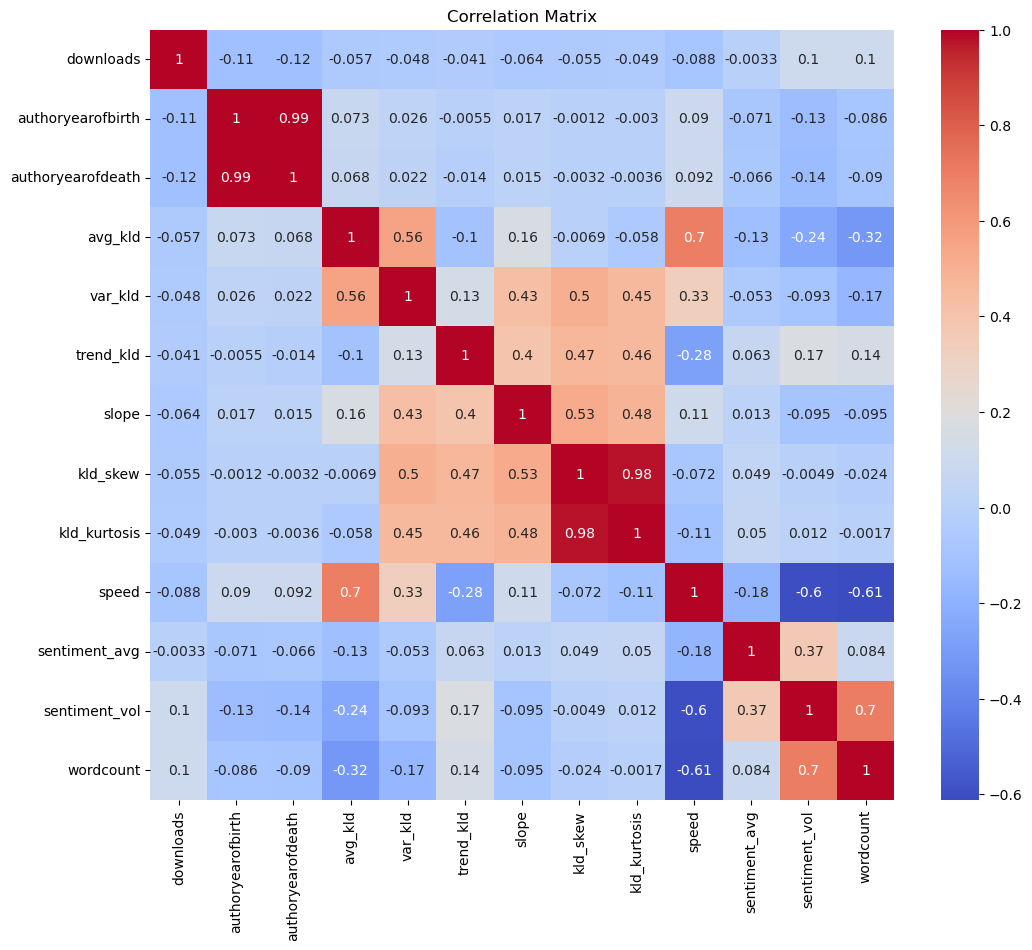

In [15]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = data[['downloads', 'authoryearofbirth', 'authoryearofdeath', 'avg_kld', 'var_kld', 'trend_kld', 'slope', 'kld_skew', 'kld_kurtosis', 'speed',
       'sentiment_avg', 'sentiment_vol', 'wordcount']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

1. Relationships Among KLD Measures:

- Average and Variance: Books with higher average KLD tend to also have higher variability.

- Variance, Skewness, and Kurtosis: Books with higher variability in KLD also tend to have more skewed and "tailed" distributions.

- Trend and Slope: An increasing trend in KLD scores is associated with a steeper slope.

2. Sentiment Measures:

- Sentiment Average and Volatility: Books with higher average sentiment also exhibit greater emotional variability.

- Volatility and Speed: Books with more emotional ups and downs tend to be read more slowly.

3. Other Notable Relationships:

- Downloads and Wordcount: Longer books tend to have slightly more downloads.

- Downloads and Sentiment Volatility: Books with more emotional variability tend to be more popular.

- Downloads and Speed: Faster-to-read books are slightly less popular.

- Downloads and Author Year of Death: Books by more recently deceased authors are less downloaded.

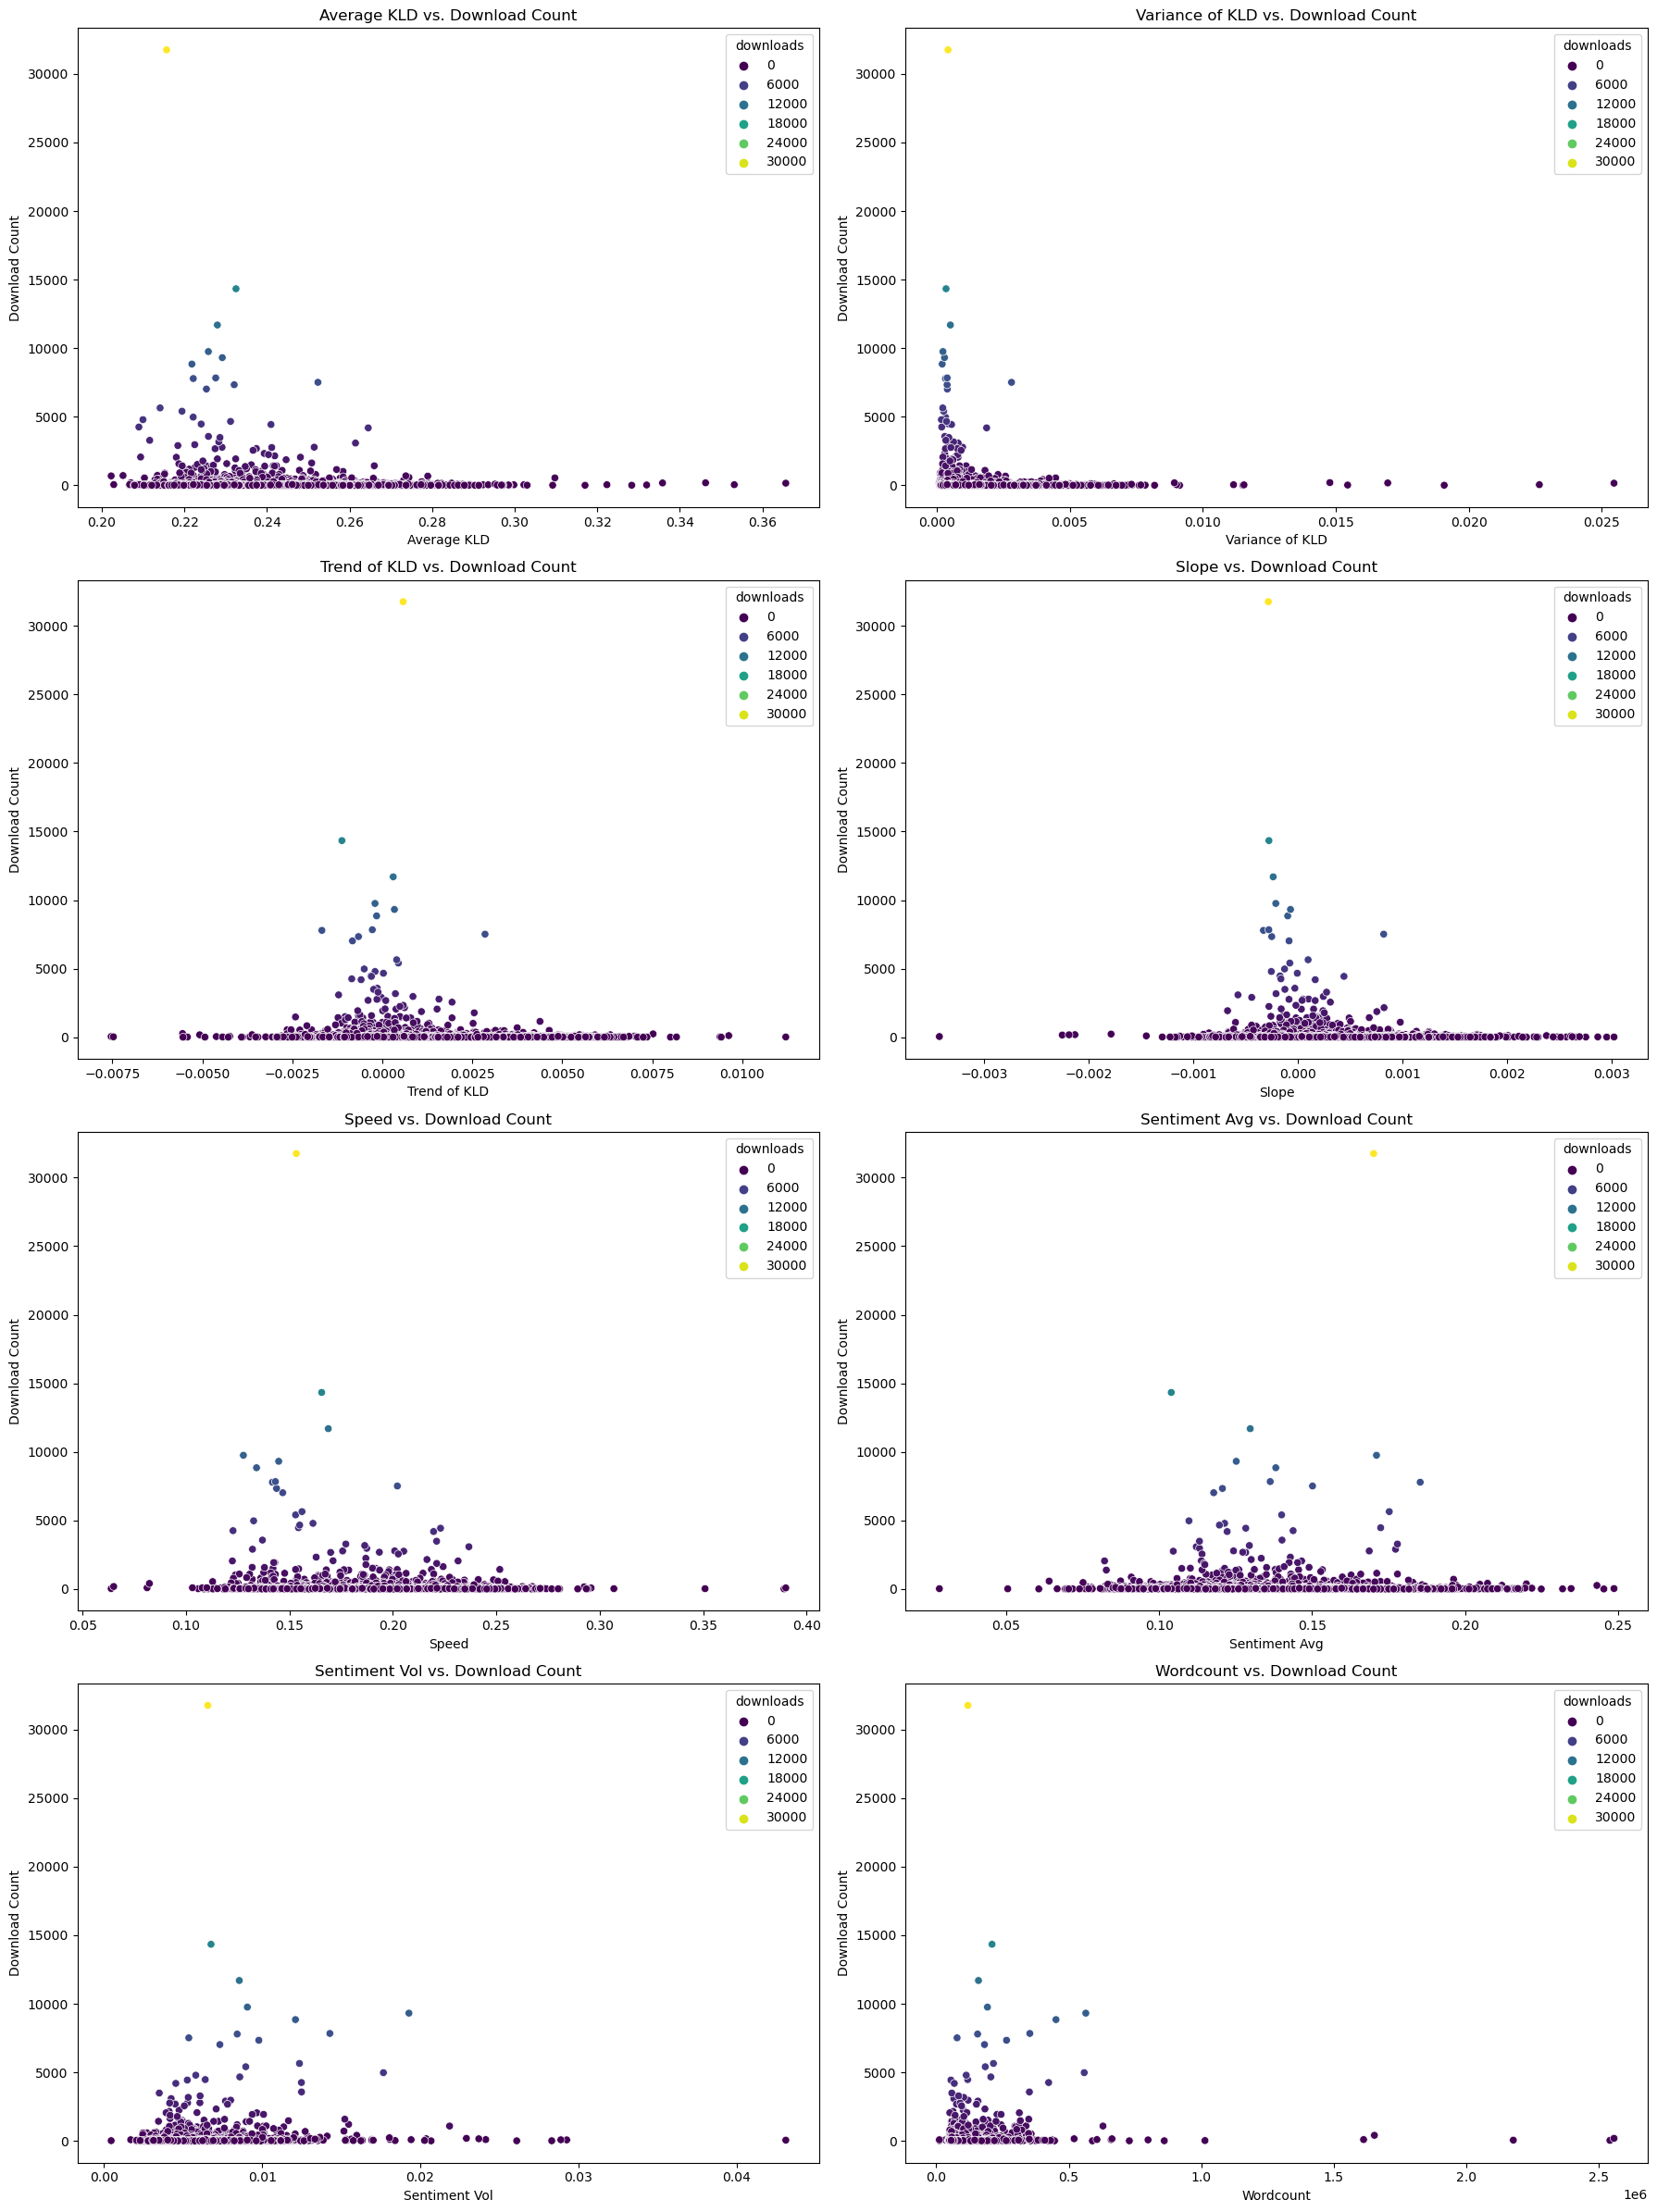

In [16]:
# SCATTERPLOTS

fig, axes = plt.subplots(4, 2, figsize=(18, 24))

# mean KLD vs. download count
sns.scatterplot(ax=axes[0, 0], x='avg_kld', y='downloads', data=data, hue='downloads', palette='viridis')
axes[0, 0].set_title('Average KLD vs. Download Count')
axes[0, 0].set_xlabel('Average KLD')
axes[0, 0].set_ylabel('Download Count')

# variance KLD vs. download count
sns.scatterplot(ax=axes[0, 1], x='var_kld', y='downloads', data=data, hue='downloads', palette='viridis')
axes[0, 1].set_title('Variance of KLD vs. Download Count')
axes[0, 1].set_xlabel('Variance of KLD')
axes[0, 1].set_ylabel('Download Count')

# trend KLD vs. download count
sns.scatterplot(ax=axes[1, 0], x='trend_kld', y='downloads', data=data, hue='downloads', palette='viridis')
axes[1, 0].set_title('Trend of KLD vs. Download Count')
axes[1, 0].set_xlabel('Trend of KLD')
axes[1, 0].set_ylabel('Download Count')

# slope vs. download count
sns.scatterplot(ax=axes[1, 1], x='slope', y='downloads', data=data, hue='downloads', palette='viridis')
axes[1, 1].set_title('Slope vs. Download Count')
axes[1, 1].set_xlabel('Slope')
axes[1, 1].set_ylabel('Download Count')

# speed vs. download count
sns.scatterplot(ax=axes[2, 0], x='speed', y='downloads', data=data, hue='downloads', palette='viridis')
axes[2, 0].set_title('Speed vs. Download Count')
axes[2, 0].set_xlabel('Speed')
axes[2, 0].set_ylabel('Download Count')

# sentiment_avg vs. download count
sns.scatterplot(ax=axes[2, 1], x='sentiment_avg', y='downloads', data=data, hue='downloads', palette='viridis')
axes[2, 1].set_title('Sentiment Avg vs. Download Count')
axes[2, 1].set_xlabel('Sentiment Avg')
axes[2, 1].set_ylabel('Download Count')

# sentiment_vol vs. download count
sns.scatterplot(ax=axes[3, 0], x='sentiment_vol', y='downloads', data=data, hue='downloads', palette='viridis')
axes[3, 0].set_title('Sentiment Vol vs. Download Count')
axes[3, 0].set_xlabel('Sentiment Vol')
axes[3, 0].set_ylabel('Download Count')

# wordcount vs. download count
sns.scatterplot(ax=axes[3, 1], x='wordcount', y='downloads', data=data, hue='downloads', palette='viridis')
axes[3, 1].set_title('Wordcount vs. Download Count')
axes[3, 1].set_xlabel('Wordcount')
axes[3, 1].set_ylabel('Download Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

1. KLD Measures vs. Download Count:

- Lower average KLD scores are associated with higher download counts, indicating a preference for content with less deviation from the average language model.
- Higher variance in KLD is linked to fewer downloads, suggesting readers prefer more consistent content.

2. Trend and Slope of KLD:

- Neither the trend nor the slope of KLD shows a significant relationship with downloads, indicating these factors do not substantially influence reader preferences.

3. Speed and Sentiment Measures:

- Books with moderate reading speeds and moderate sentiment averages tend to have higher downloads, showing a preference for balanced and emotionally moderate content.
- Moderate sentiment volatility is also associated with higher downloads, suggesting readers prefer some emotional variability but not too much.

4. Wordcount:

- Books with moderate word counts have higher download counts, indicating a preference for books that are neither too short nor too long.

### 2. Regression Analysis (To analyze Relationship between information revelation and book popularity)

In [17]:
data.isna().sum()

id                         0
title                      0
author                   191
authoryearofbirth       1148
authoryearofdeath       1218
language                   0
downloads                  0
subjects                   0
type                       0
kld_values                 0
avg_kld                    0
var_kld                    0
slope                      0
trend_kld                  0
kld_skew                   0
kld_kurtosis               0
subj2_war                  0
subj2_adventure            0
subj2_comedy               0
subj2_biography            0
subj2_romance              0
subj2_drama                0
subj2_fantasy              0
subj2_family               0
subj2_sciencefiction       0
subj2_action               0
subj2_thriller             0
subj2_western              0
subj2_horror               0
subj2_mystery              0
subj2_crime                0
subj2_history              0
subj2_periodicals          0
subj2_others               0
speed         

In [18]:
data.dtypes

id                       object
title                    object
author                   object
authoryearofbirth       float64
authoryearofdeath       float64
language                 object
downloads               float64
subjects                 object
type                     object
kld_values               object
avg_kld                 float64
var_kld                 float64
slope                   float64
trend_kld               float64
kld_skew                float64
kld_kurtosis            float64
subj2_war                 int64
subj2_adventure           int64
subj2_comedy              int64
subj2_biography           int64
subj2_romance             int64
subj2_drama               int64
subj2_fantasy             int64
subj2_family              int64
subj2_sciencefiction      int64
subj2_action              int64
subj2_thriller            int64
subj2_western             int64
subj2_horror              int64
subj2_mystery             int64
subj2_crime               int64
subj2_hi

In [19]:
# Droping rows with Null values
data.dropna(subset=['speed', 'sentiment_avg', 'sentiment_vol', 'wordcount', 'authoryearofbirth', 'authoryearofdeath'], inplace=True)

In [20]:
X = data[['authoryearofbirth', 'authoryearofdeath', 'avg_kld', 'var_kld', 'slope', 'trend_kld', 'kld_skew', 'kld_kurtosis',
       'subj2_war', 'subj2_adventure', 'subj2_comedy', 'subj2_biography',
       'subj2_romance', 'subj2_drama', 'subj2_fantasy', 'subj2_family',
       'subj2_sciencefiction', 'subj2_action', 'subj2_thriller',
       'subj2_western', 'subj2_horror', 'subj2_mystery', 'subj2_crime',
       'subj2_history', 'subj2_periodicals', 'subj2_others', 'speed',
       'sentiment_avg', 'sentiment_vol', 'wordcount']]
y = data['downloads']

X = sm.add_constant(X)

In [21]:
# Fitting regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              downloads   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     12.17
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           5.37e-54
Time:                        10:50:57   Log-Likelihood:                -55241.
No. Observations:                7134   AIC:                         1.105e+05
Df Residuals:                    7105   BIC:                         1.107e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1374.4721 

- The above analysis suggests that genre and sentiment measures have some impacts on downloads, with certain genres like romance and horror, and sentiment volatility being positive predictors meaning having higher downloads, while others like biography, history, other, and average sentiment having negative impacts which means there are fewer donloads. 

### 3. Investigating Heterogeneity and LASSO

In [22]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# LASSO regression
lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)

lasso_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
lasso_coefficients = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]

lasso_coefficients

,Feature,Coefficient
2,authoryearofdeath,-21.324994
21,subj2_horror,0.487228
29,sentiment_vol,13.183721
30,wordcount,0.778837


Model Insights:

- LASSO regression effectively selects the most relevant features, reducing potential overfitting by setting less important feature coefficients to zero.
- The identified features highlight the importance of author-related characteristics, genre, sentiment, and book length in predicting book downloads.
- The variable "authoryearofdeath" significantly decreases the number of downloads.
- Variables such as "subj2_horror", "sentiment_vol", and "wordcount" positively influence the number of downloads.

In [24]:
# Investigating heterogeneity by genres
genres = ['subj2_war', 'subj2_adventure','subj2_biography', 'subj2_romance', 'subj2_drama', 'subj2_fantasy',
          'subj2_family', 'subj2_sciencefiction', 'subj2_western', 'subj2_horror', 'subj2_mystery', 'subj2_crime', 
          'subj2_history', 'subj2_others']

In [25]:
data[(data["subj2_periodicals"] == 1)]

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,kld_values,...,subj2_horror,subj2_mystery,subj2_crime,subj2_history,subj2_periodicals,subj2_others,speed,sentiment_avg,sentiment_vol,wordcount
4945,PG30637,"Writings in the United Amateur, 1915-1922","Lovecraft, H. P. (Howard Phillips)",1890.0,1937.0,['en'],321.0,"{'Periodicals', 'Literature -- History and cri...",Text,"[0.24699002309065432, 0.23487991785636544, 0.2...",...,0,0,0,1,1,0,0.197166,0.18596,0.005806,93937.0


In [26]:
for genre in genres:
    genre_df = data[data[genre] == 1]
    X_genre = genre_df[['avg_kld', 'var_kld', 'slope', 'trend_kld', 'kld_skew', 'kld_kurtosis', 'speed', 'sentiment_avg', 'sentiment_vol', 'wordcount', 'authoryearofdeath', 'authoryearofdeath']]
    y_genre = genre_df['downloads']
    X_genre = sm.add_constant(X_genre)
    
    model_genre = sm.OLS(y_genre, X_genre).fit()
    print(f"Regression results for genre: {genre}")
    print(model_genre.summary())

Regression results for genre: subj2_war
                            OLS Regression Results                            
Dep. Variable:              downloads   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     20.01
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           8.58e-34
Time:                        10:50:57   Log-Likelihood:                -4086.2
No. Observations:                 535   AIC:                             8196.
Df Residuals:                     523   BIC:                             8248.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

/Users/navisha/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We can draw the following insights from the above analysis 

1. Speed and Wordcount: Across multiple genres such as War, Adventure, and Mystery, higher reading speed and larger wordcount consistently show a positive relationship with the number of downloads. This indicates that readers prefer books that are either quick to read or have more content.

2. Author Year of Death: In genres like War, Romance, Fantasy, and Others, the year of an author's death negatively impacts downloads. Books by authors who died more recently tend to have fewer downloads, potentially indicating a preference for older, classic works.

3. Sentiment Volatility: In genres like Adventure, Western, and Others, sentiment volatility (the variability of emotional tone) has a significant impact. Higher sentiment volatility is positively associated with downloads in Western and Others genres, suggesting that readers may be drawn to books with more emotional variability.

4. Sentiment Average: In Science Fiction and Others, higher average sentiment (overall emotional tone) negatively influences downloads. This implies that books with a more consistently positive or negative tone may be less appealing to readers.

5. Trend and Average KLD: The KLD measures show varied impacts. In the Adventure and Others genres, a decreasing trend in KLD negatively impacts downloads, suggesting that books with more unique or evolving content are preferred. Conversely, in Mystery, higher average KLD is associated with fewer downloads, indicating a preference for less complex or more predictable content.

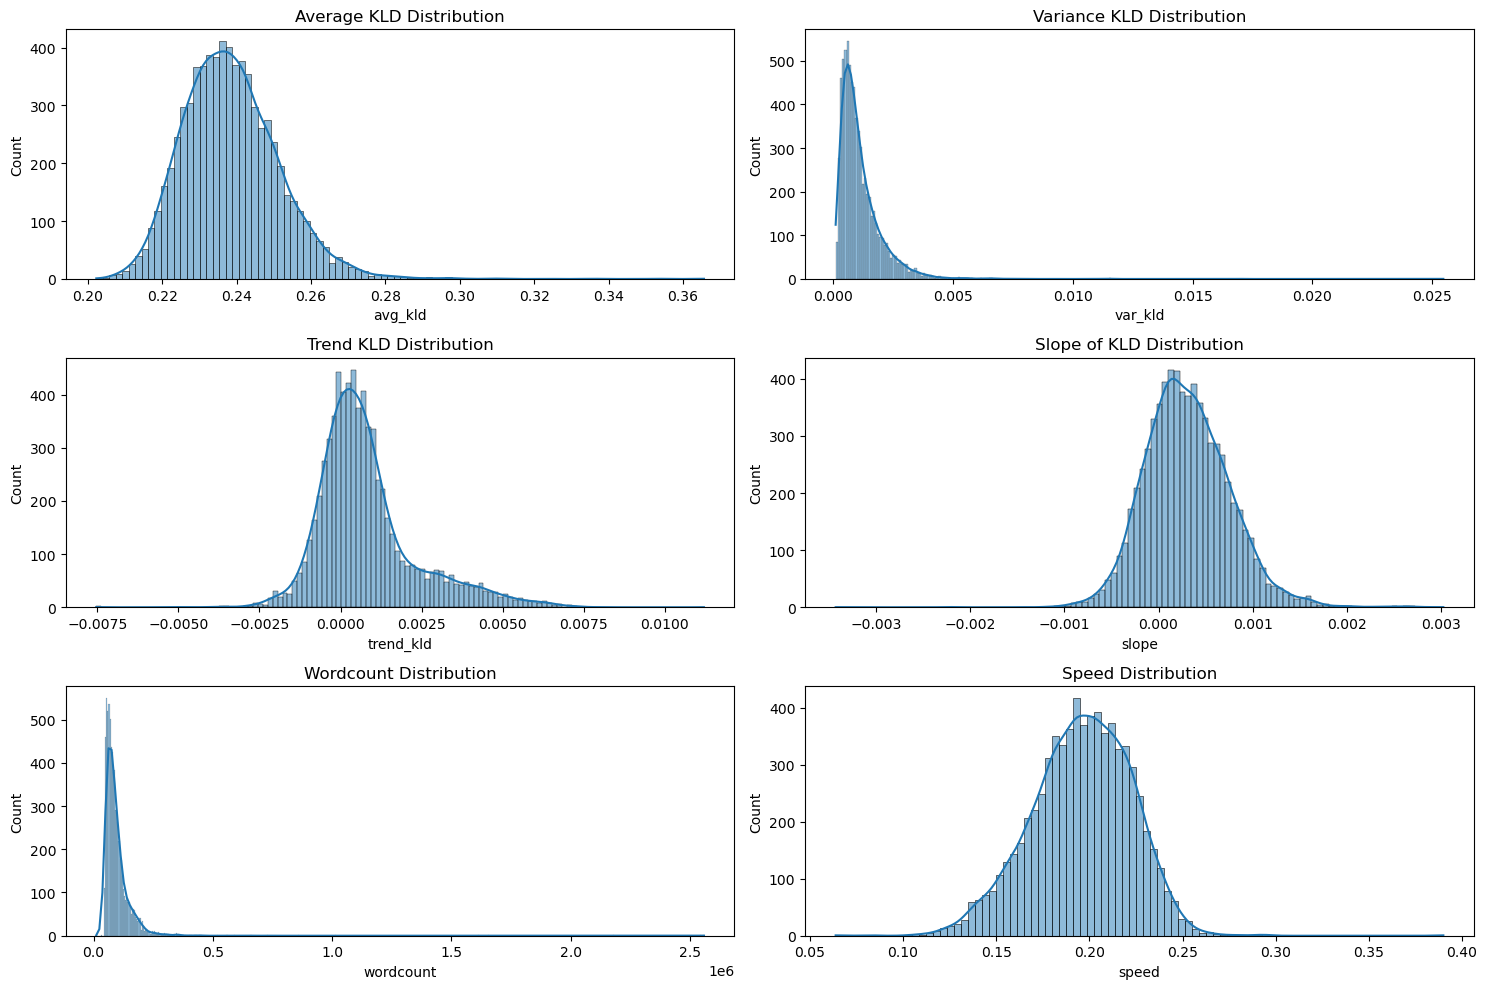

In [27]:
#HISTOGRAMS

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Average KLD
sns.histplot(data['avg_kld'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Average KLD Distribution')

# Variance KLD
sns.histplot(data['var_kld'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Variance KLD Distribution')

# Trend KLD
sns.histplot(data['trend_kld'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Trend KLD Distribution')

# Slope of KLD
sns.histplot(data['slope'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Slope of KLD Distribution')

# Slope of KLD
sns.histplot(data['wordcount'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Wordcount Distribution')

# Slope of KLD
sns.histplot(data['speed'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Speed Distribution')


plt.tight_layout()
plt.show()